# Sequence Learning - Direct - English - Testing Session - Phonological Testings
Version 1: We should conduct the following tests:   
1. Clustering test: i.e. for the whole bunch of phones we do a clustering task. Check the degree of alignment between clustered clusters and the ground truth tag of the tokens. 

2. of course we should plot out the phones and words to check whether they are well distinguishable from the hidden representation. 

In [1]:
import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [2]:
from padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from my_utils import *
from loss import *
from model import SimplerPhxLearner
from dataset import SeqDatasetAnno, MelSpecTransform
from my_dataset import DS_Tools
from reshandler import AnnoEncoderResHandler
from misc_progress_bar import draw_progress_bar
from bnd_detect_tools import *

## Preps

### Dirs

In [3]:
model_save_dir = model_eng_save_dir

log_path = phone_seg_anno_log_path
rec_path = phone_seg_anno_path

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

INPUT_DIM = 64
OUTPUT_DIM = 64

INTER_DIM_0 = 32
INTER_DIM_1 = 16
INTER_DIM_2 = 8

ENC_SIZE_LIST = [INPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]
DEC_SIZE_LIST = [OUTPUT_DIM, INTER_DIM_0, INTER_DIM_1, INTER_DIM_2]

DROPOUT = 0.5

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Model

### Model-related defs

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

model = SimplerPhxLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [6]:
load_ts = "0926172946"
stop_epoch = "194"

In [7]:
model_raw_name = "PT_{}_{}_full".format(load_ts, stop_epoch)
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

SimplerPhxLearner(
  (encoder): RLEncoder(
    (rnn): LSTM(64, 16, num_layers=2, batch_first=True)
    (lin_2): LinearPack(
      (linear): Linear(in_features=16, out_features=8, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (decoder): RALDecoder(
    (rnn): LSTM(64, 8, num_layers=2, batch_first=True)
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_3): LinearPack(
      (linear): Linear(in_features=8, out_features=64, bias=True)
      (relu): Tanh()
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
)

### Dataset

- Note that due to the separate setting of word and phone datasets, we cannot really make it to select those that have not been trained on 
for this test. This is a point to further fix. Make reference to out first work. 

In [11]:
mytrans = MelSpecTransform(sample_rate=REC_SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS)
ds = SeqDatasetAnno(rec_path, os.path.join(log_path, "log.csv"), transform=mytrans)

# # this is to reduce the size of the dataset when the training power is not sufficient
small_len = int(0.05 * len(ds))
other_len = len(ds) - small_len

# # Randomly split the dataset into train and validation sets
valid_ds, other_ds = random_split(ds, [small_len, other_len])

valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=SeqDatasetAnno.collate_fn)
valid_num = len(valid_loader.dataset)

In [12]:
valid_num

41640

## Inference

In [19]:
def infer(): 
    model.eval()
    reshandler = AnnoEncoderResHandler(whole_res_dir=cluster_res_path, file_prefix=model_raw_name)
    all_res = np.empty((0, INTER_DIM_2))
    all_token = []
    all_pred = []   # we use .name to store cluster preds

    total = len(valid_loader)

    for idx, (x, x_lens, token, name) in enumerate(valid_loader): 
        token = token[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        hid_r = model.encode(x, x_lens, x_mask)

        hid_r = hid_r.cpu().detach().numpy().squeeze()

        length = hid_r.shape[0]

        all_res = np.concatenate((all_res, hid_r), axis=0)
        all_token += [token] * length

        if idx % 10 == 0: 
            draw_progress_bar(idx, total)
    

    reshandler.res = all_res
    reshandler.tok = all_token
    reshandler.name = all_pred
    reshandler.save()

In [20]:
if __name__ == "__main__": 
    infer()

[==================================================] 99%	

# Load Res

In [21]:
reshandler = AnnoEncoderResHandler(whole_res_dir=cluster_res_path, file_prefix=model_raw_name)
reshandler.read()

# Cluster Evaluation

In [22]:
# all
all_res = reshandler.res
all_tokens = reshandler.tok

In [23]:
num_phones = np.unique(all_tokens).shape[0]
kmeansmodel = KMeans(n_clusters=num_phones) # , random_state=0
clusters = kmeansmodel.fit_predict(all_res)

/home/ldlmdl/anaconda3/envs/wavln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
reshandler.name = clusters
reshandler.save()

In [38]:
np.min(all_res), np.max(all_res)

(-0.9559100866317749, 0.9706265330314636)

In [31]:
h, c, v = homogeneity_completeness_v_measure(all_tokens, clusters)
print(h, c, v)

0.031164129315317465 0.032152346533527006 0.03165052608277854


In [39]:
# comparison: baseline - random hidrep
all_base = np.random.uniform(low=-1, high=1, size=all_res.shape)
kmeansmodel_base = KMeans(n_clusters=num_phones) # , random_state=0
clusters_base = kmeansmodel_base.fit_predict(all_base)

/home/ldlmdl/anaconda3/envs/wavln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [40]:
h, c, v = homogeneity_completeness_v_measure(all_tokens, clusters_base)
print(h, c, v)

0.0017489635727399044 0.001497455763794559 0.0016134672149050587


In [71]:
mismatch_counter = 0
total_counter = 0

for ms in all_matching_status: 
    if ms != 1: 
        mismatch_counter += 1
    total_counter += 1

print(mismatch_counter, total_counter, mismatch_counter/total_counter)

17514 56808 0.3083016476552598


In [72]:
# mismatcher_out: exclude those that are not matching
preds_misout = []
bnds_misout = []
for idx in range(len(all_preds)): 
    if all_matching_status[idx] != 1: 
        continue
    preds_misout.append(all_preds[idx])
    bnds_misout.append(all_bnds[idx])

In [73]:
len(preds_misout)

39294

In [74]:
one_counter = 0
total_counter = 0

for bnd in bnds_misout: 
    if len(bnd) <= 1: 
        one_counter += 1
    total_counter += 1

print(one_counter, total_counter, one_counter/total_counter)

5145 39294 0.13093602076652924


In [75]:
# one_bound_out: bnds excludes last
preds = []
bnds = []
for idx in range(len(preds_misout)): 
    if len(bnds_misout[idx]) <= 1: 
        continue
    preds.append(preds_misout[idx])
    bnds.append(bnds_misout[idx][:-1])

In [76]:
len(bnds)

34149

In [77]:
periodic_preds = periodic_bnd_detect(preds, every=4, only_then_rand=False)

In [78]:
pb_precision_list, pb_recall_list = [], []

#Recall
for i in range(len(bnds)):
    single_utt_recall = tolerance_recall(bnds[i], \
                            periodic_preds[i], tolerance_window=2)
    pb_recall_list.append(single_utt_recall)

#Precision
for i in range(len(periodic_preds)):
    single_utt_precision = tolerance_precision(bnds[i], \
                            periodic_preds[i], tolerance_window=2)
    pb_precision_list.append(single_utt_precision)


precision = sum(pb_precision_list) / len(pb_precision_list)
recall = sum(pb_recall_list) / len(pb_recall_list)
recall *= 100
precision *= 100
if recall == 0. or precision == 0.:
    f_score = -1.
    r_val = -1.
else:
    f_score = (2 * precision * recall) / (precision + recall)
    r_val = r_val_eval(precision, recall)

print("R-value for periodic boundary prediction is: {}".format(r_val))

R-value for periodic boundary prediction is: 39.91516240632615


## Run a through search through all dims

In [82]:
dims = list(range(8)) + ["mean"]
th = [0.05, 0.04, 0.035, 0.03]
th += [0.029, 0.028, 0.027, 0.026, 0.025, 0.024, 0.023, 0.022, 0.021, 0.02, 0.019]
th += [0.018, 0.017, 0.016, 0.015, 0.014, 0.013, 0.012, 0.011, 0.01]
th += [0.0008, 0.0007]
th_total = len(th)

recall_lslsls, precision_lslsls, r_val_lslsls = [], [], []

for idx, dim in enumerate(dims): 
    recall_lsls, precision_lsls, r_val_ls = [], [], []
    
    for idx, thresh in enumerate(th): 
        recall_list, precision_list = thresh_segmentation_eval(batch_delta_hrs(preds, sel=dim, minus=True), bnds, tolerance_window=2, diff_thresh_factor=thresh)
        recall_lsls.append(recall_list)
        precision_lsls.append(precision_list)

    for th_idx in range(len(th)): 
        precision_list = precision_lsls[th_idx]
        recall_list = recall_lsls[th_idx]

        precision = sum(precision_list) / len(precision_list)
        recall = sum(recall_list) / len(recall_list)
        recall *= 100
        precision *= 100
        if recall == 0. or precision == 0.:
            f_score = -1.
            r_val = -1.
        else:
            f_score = (2 * precision * recall) / (precision + recall)
            r_val = r_val_eval(precision, recall)
        
        r_val_ls.append(r_val)
    
    recall_lslsls.append(recall_lsls)
    precision_lslsls.append(precision_lsls)
    r_val_lslsls.append(r_val_ls)
    
    print('The best r_val is: {:.4f}, th = {}, dim = {}'.format(max(r_val_ls), th[r_val_ls.index(max(r_val_ls))], dim))

The best r_val is: 65.7820, th = 0.022, dim = 0
The best r_val is: 56.9682, th = 0.05, dim = 1
The best r_val is: 62.9366, th = 0.013, dim = 2
The best r_val is: 65.3444, th = 0.035, dim = 3
The best r_val is: 48.8134, th = 0.0007, dim = 4
The best r_val is: 65.5650, th = 0.01, dim = 5
The best r_val is: 65.8948, th = 0.028, dim = 6
The best r_val is: 62.9579, th = 0.017, dim = 7
The best r_val is: 66.3815, th = 0.027, dim = mean


In [59]:
# Plus
"""
The best r_val is: 64.1704, th = 0.027, dim = 0
The best r_val is: 29.5702, th = 0.0008, dim = 1
The best r_val is: 62.8208, th = 0.019, dim = 2
The best r_val is: 64.6059, th = 0.03, dim = 3
The best r_val is: 49.6899, th = 0.003, dim = 4
The best r_val is: 67.6130, th = 0.008, dim = 5
The best r_val is: 35.5558, th = 0.0008, dim = 6
The best r_val is: 63.5690, th = 0.022, dim = 7
The best r_val is: 55.5981, th = 0.0008, dim = mean
"""

# Minus
"""
The best r_val is: 65.9907, th = 0.024, dim = 0
The best r_val is: 51.9334, th = 0.035, dim = 1
The best r_val is: 62.7616, th = 0.01, dim = 2
The best r_val is: 65.6081, th = 0.03, dim = 3
The best r_val is: 49.1389, th = 0.0008, dim = 4
The best r_val is: 65.7445, th = 0.01, dim = 5
The best r_val is: 65.8716, th = 0.027, dim = 6
The best r_val is: 63.0764, th = 0.019, dim = 7
The best r_val is: 66.7116, th = 0.027, dim = mean
"""


"""
The best r_val is: 64.1667, th = 0.028, dim = 0
The best r_val is: 29.5675, th = 0.001, dim = 1
The best r_val is: 62.7918, th = 0.02, dim = 2
The best r_val is: 64.6059, th = 0.03, dim = 3
The best r_val is: 49.6220, th = 0.004, dim = 4
The best r_val is: 67.6130, th = 0.008, dim = 5
The best r_val is: 35.5199, th = 0.001, dim = 6
The best r_val is: 63.5690, th = 0.022, dim = 7
The best r_val is: 55.5489, th = 0.001, dim = mean
"""

'\nThe best r_val is: 64.1667, th = 0.028, dim = 0\nThe best r_val is: 29.5675, th = 0.001, dim = 1\nThe best r_val is: 62.7918, th = 0.02, dim = 2\nThe best r_val is: 64.6059, th = 0.03, dim = 3\nThe best r_val is: 49.6220, th = 0.004, dim = 4\nThe best r_val is: 67.6130, th = 0.008, dim = 5\nThe best r_val is: 35.5199, th = 0.001, dim = 6\nThe best r_val is: 63.5690, th = 0.022, dim = 7\nThe best r_val is: 55.5489, th = 0.001, dim = mean\n'

# Plot some hidrep graphs in relation to boundary

In [18]:
def plot_feature_with_boundaries(features, boundaries, name):
    num_features = features.shape[1]
    num_samples = features.shape[0]

    time_axis = np.arange(num_samples)

    fig, axes = plt.subplots(num_features + 1, 1, figsize=(10, (num_features + 1) * 2), sharex=True)

    # Plot each feature on separate subplots
    for i in range(num_features):
        ax = axes[i]
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}')

        for boundary in boundaries:
            if boundary < num_samples:
                ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

        ax.set_ylabel(f'Feature {i + 1}')

    # Plot all dimensions together with different line colors
    ax = axes[num_features]
    for i in range(num_features):
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}', alpha=0.5)

    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    ax.set_ylabel('All Features')
    ax.legend()

    plt.xlabel('Time (frames)')

    plt.tight_layout()
    # plt.show()
    plt.savefig("./8dim_hrs/" + "{}_dim.png".format(name))
    plt.close()

In [19]:
def plot_mean_feature_with_boundaries(features, boundaries, name):
    """
    Plot the mean of the features as a line graph with marked boundaries.
    
    Parameters:
    - features: NumPy array of shape (length, 8)
    - boundaries: List of boundary times (frame numbers)
    """
    num_samples = features.shape[0]

    # Create a time axis
    time_axis = np.arange(num_samples)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(time_axis, features, label='Mean Feature')

    # Mark boundaries on the plot
    for boundary in boundaries:
        if boundary < num_samples:
            plt.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    # Set labels and legend
    plt.xlabel('Time (frames)')
    plt.ylabel('Mean Feature Value')
    plt.legend()
    
    # plt.show()
    plt.savefig("./8dim_hrs/" + "{}_mean.png".format(name))
    plt.close()

In [37]:
def plot_all_and_mean_feature_with_boundaries(features, mean_features, boundaries, name):
    """
    Plot the mean of the features as a line graph with marked boundaries.
    
    Parameters:
    - features: NumPy array of shape (length, 8)
    - boundaries: List of boundary times (frame numbers)
    """
    num_features = features.shape[1]
    num_samples = features.shape[0]

    # Create a time axis
    time_axis = np.arange(num_samples)

    # Create the plot
    # plt.figure(figsize=(10, 6))
    fig, axes = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
    # Plot all dimensions together with different line colors

    ax = axes[0]
    ax.plot(time_axis, mean_features, label='Mean Feature')

    # Mark boundaries on the plot
    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)

    ax.set_ylabel('Mean Feature Value')

    ax = axes[1]
    for i in range(num_features):
        ax.plot(time_axis, features[:, i], label=f'Feature {i + 1}', alpha=0.5)

    for boundary in boundaries:
        if boundary < num_samples:
            ax.axvline(x=boundary, color='red', linestyle='--', alpha=0.5)
    
    ax.set_ylabel('All Features')
    # ax.legend()

    # Set labels and legend
    plt.xlabel('Time (frames)')
    
    # plt.legend()
    
    plt.show()
    # plt.savefig("./8dim_hrs/" + "{}_mean.png".format(name))
    # plt.close()

In [38]:
spec_idx = reshandler.name.index("s0502a_00000395")

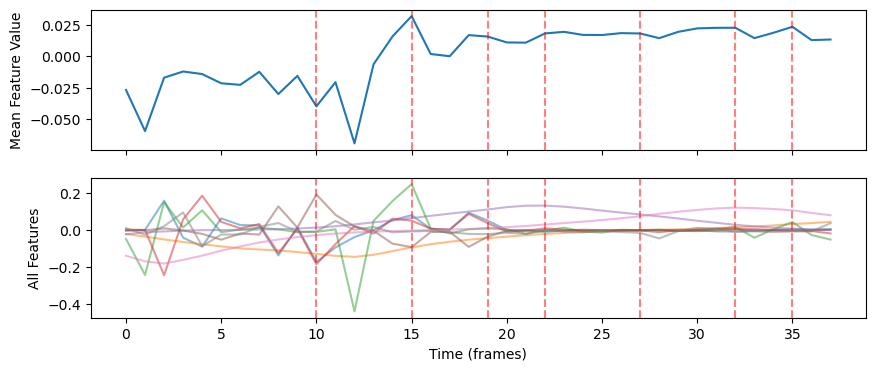

In [39]:
name = reshandler.name[spec_idx]
pred = reshandler.res[spec_idx]
bnd = reshandler.tok[spec_idx]

delta = delta_hrs(pred)
pred_mean = pred.mean(axis=1)
delta_mean = delta_hrs(pred_mean)
# delta = pred
plot_all_and_mean_feature_with_boundaries(delta, delta_mean, bnd, name)

In [23]:
mk("./8dim_hrs")

In [24]:
total_len = len(reshandler.name)

In [26]:
spec_idx = reshandler.name.index("s0502a_00000395")

In [27]:
name = reshandler.name[spec_idx]
pred = reshandler.res[spec_idx]
bnd = reshandler.tok[spec_idx]

delta = delta_hrs(pred)
# delta = pred
plot_feature_with_boundaries(delta, bnd, name)

pred_mean = pred.mean(axis=1)
delta = delta_hrs(pred_mean)
# delta = pred_mean
plot_mean_feature_with_boundaries(delta, bnd, name)

In [25]:
for i in range(20): 
    randidx = random.randint(0, total_len)
    name = reshandler.name[randidx]
    pred = reshandler.res[randidx]
    bnd = reshandler.tok[randidx]

    # delta = delta_hrs(pred)
    delta = pred
    plot_feature_with_boundaries(delta, bnd, name)

    pred_mean = pred.mean(axis=1)
    # delta = delta_hrs(pred_mean)
    delta = pred_mean
    plot_mean_feature_with_boundaries(delta, bnd, name)